In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Define CNN model

In [ ]:
# NOTE: Define a CNN model for MNIST dataset and load the model weights

import torch
import torch.nn as nn
import numpy as np
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import torch.distributions as dist
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Define the CNN model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)
        x = torch.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = torch.log_softmax(x, dim=1)
        return output


model = Net().to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Load the MNIST dataset
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
)

trainset = MNIST(root="./data", train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

testset = MNIST(root="./data", train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=1000, shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:10<00:00, 966869.74it/s] 


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 151619.00it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1453069.16it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 7346906.58it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



## Load CNN Weights

In [ ]:
# save the mode weights in .pth format (99.25% accuracy
# torch.save(model.state_dict(), 'CNN_MNSIT.pth')

# NOTE: load the model weights

model.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/CNN_MNSIT.pth"))

<All keys matched successfully>

## Inital image setup

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1374: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


ID: 61, True y = 8, probability: 0.99983
pixel from 2.821486711502075 to -0.4242129623889923


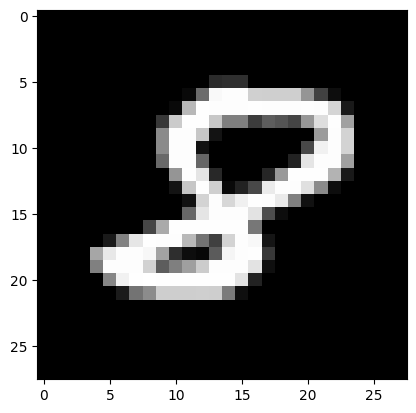

<Figure size 640x480 with 0 Axes>

In [ ]:

img_id = 61   # ID61 is the number 8
input = testset[img_id]
img = input[0].squeeze(0).clone()
# img = transform(img)
plt.imshow(img, cmap="gray")
plt.savefig(f"ID {img_id}-Digit {input[1]} original_image.png")
print(
    f"ID: {img_id}, True y = {input[1]}, probability: {F.softmax(model(input[0].unsqueeze(0)), dim=1).max():.5f}"
)
print(f"pixel from {img.max()} to {img.min()}")
plt.show()
plt.clf()


## Saliency Map

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1374: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


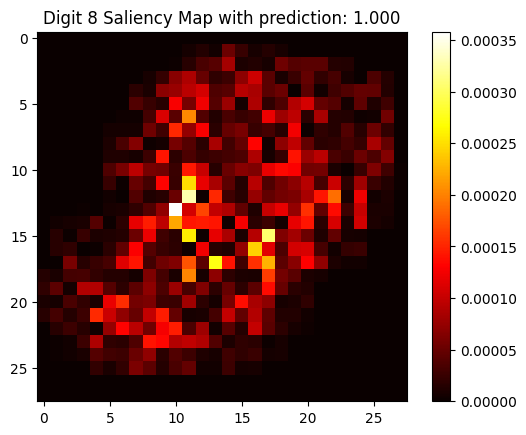

max pixel value: 0.00035800106707029045, min pixel value: 0.0


<Figure size 640x480 with 0 Axes>

In [ ]:
# NOTE: The model in XAI saliency map evaluation
# Wrap the image in a Variable, set requires_grad=True to compute gradients
image = torch.autograd.Variable(
    img.clone().unsqueeze(0).unsqueeze(0), requires_grad=True
)

# Forward pass
outputs = model(image)

# Get the index of the max log-probability
_, predicted = outputs.max(1)

# Zero the gradients of the model parameters
model.zero_grad()

# Backward pass
outputs[0, predicted].backward()
# The saliency map is in the grad of the image
saliency_map = image.grad.data.abs().max(dim=1)[0]


# Convert the saliency map from Torch Tensor to numpy array and display it
saliency_map = saliency_map.numpy()
plt.imshow(saliency_map[0], cmap=plt.cm.hot)
# New code to add a colorbar
plt.title(f"Digit {input[1]} Saliency Map with prediction: {F.softmax(model(image), dim=1).max():.3f}")
plt.colorbar()
plt.savefig(f"ID {img_id}-Digit {input[1]} saliency_map.png")
plt.show()
plt.clf()
print(f"max pixel value: {saliency_map.max()}, min pixel value: {saliency_map.min()}")

## VI Model

In [ ]:
# NOTE: The model in VI evaluation
# TODO: ADD ELBO in the model


def ll_gaussian(y, mu, log_var):
    sigma = torch.exp(0.5 * log_var)
    return -0.5 * torch.log(2 * np.pi * sigma**2) - (1 / (2 * sigma**2)) * (y - mu) ** 2


class VI(nn.Module):
    def __init__(self):
        super().__init__()

        self.q_mu = nn.Sequential(
            nn.Linear(784, 20),
            nn.ReLU(),
            nn.Linear(20, 10),
            nn.ReLU(),
            nn.Linear(10, 784),
        )
        self.q_log_var = nn.Sequential(
            nn.Linear(784, 20),
            nn.ReLU(),
            nn.Linear(20, 10),
            nn.ReLU(),
            nn.Linear(10, 784),
        )

    def reparameterize(self, mu, log_var):
        # std can not be negative, thats why we use log variance
        sigma = torch.exp(0.5 * log_var) + 1e-5
        eps = torch.randn_like(sigma)
        return mu + sigma * eps

    def forward(self, x):
        mu = self.q_mu(x)
        log_var = self.q_log_var(x)
        return self.reparameterize(mu, log_var), mu, log_var

In [ ]:
def elbo(y_pred, y, mu, log_var, model=model, predicted=predicted):
    # HACK: use the CNN model predition as the input
    model.eval()
    input = y_pred.view(1, 1, 28, 28)
    # Forward pass
    outputs = model(input)

    log_p_y = torch.log(F.softmax(outputs, dim=1)[:, predicted])
    sigma = log_var.exp() ** 0.5
    # likelihood of observing y given Variational mu and sigma
    likelihood = dist.Normal(mu, sigma).log_prob(y)

    # prior probability of y_pred
    log_prior = dist.Normal(0, 1).log_prob(y_pred)

    # variational probability of y_pred
    log_p_q = dist.Normal(mu, sigma).log_prob(y_pred)

    # by taking the mean we approximate the expectation
    return (log_p_y + likelihood + log_prior - log_p_q).mean()


def det_loss(y_pred, y, mu, log_var, model=model, predicted=predicted):
    return -elbo(y_pred, y, mu, log_var, model, predicted)

### Training VI

In [ ]:
# NOTE: Train the VI model
# HACK: if not specify "predicted" digits, than will attack to certain become another value
epochs = 5000

m = VI()
optim = torch.optim.Adam(m.parameters(), lr=0.005)

Y = torch.rand(784).clone()

for epoch in range(epochs+1):
    X = torch.rand(784).clone()
    # Y = torch.rand(784).clone()
    # X = img.view(784).clone()
    # Y = img.view(784).clone()
    # if epoch <= 2000:
    #   X = torch.rand(784).clone()
    #   Y = img.view(784).clone()
    # else:
    #   X = img.view(784).clone()
    #   Y = mu.view(784).clone().detach()
    #   Y.requires_grad = True
    optim.zero_grad()
    y_pred, mu, log_var = m(X)

    # Get the index of the max log-probability

    # loss = det_loss(y_pred, Y, mu, log_var, model, input[1])

    # try view different digit
    loss = det_loss(y_pred, Y, mu, log_var, model, 3)

    if epoch % 500 == 0:
        print(f"epoch: {epoch}, loss: {loss}")
        Y = mu.view(784).clone().detach()
        Y.requires_grad = True

    loss.backward(retain_graph=True)
    # loss.backward()
    optim.step()

epoch: 0, loss: 3.311681032180786
epoch: 500, loss: 1.0605897903442383
epoch: 1000, loss: 0.9078938961029053
epoch: 1500, loss: 0.9232466816902161
epoch: 2000, loss: 0.7930117249488831
epoch: 2500, loss: 0.7450507879257202
epoch: 3000, loss: 0.718924880027771
epoch: 3500, loss: 0.6836676597595215
epoch: 4000, loss: 0.6124453544616699
epoch: 4500, loss: 0.5991092324256897
epoch: 5000, loss: 0.5944231748580933


### Show Surrogate model

tensor(0.8464)
True y = 8, the highest probability: 1.00000
New image full model prediction: tensor([[5.3582e-13, 5.9826e-09, 2.1826e-08, 1.0000e+00, 1.8182e-11, 3.7121e-07,
         1.1844e-11, 5.4970e-07, 3.2066e-09, 2.8048e-08]],
       grad_fn=<SoftmaxBackward0>)


<ipython-input-49-c1307dfb0bb1>:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print(f"New image full model prediction: {F.softmax(model(new_image))}")


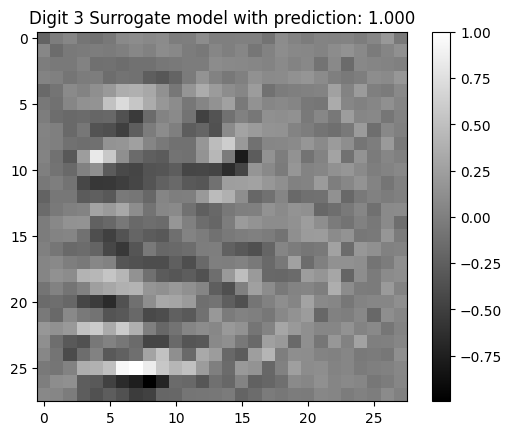

<Figure size 640x480 with 0 Axes>

In [ ]:

with torch.no_grad():
    X = img.view(784).clone()
    Y = img.view(784).clone()
    y_pred, mu, log_var = m(X)
    print(torch.abs(y_pred - Y).mean())

new_image = mu.view(1, 1, 28, 28)
F.softmax(model(new_image), dim=1).max()
print(
    f"True y = {input[1]}, the highest probability: {F.softmax(model(new_image), dim=1).max():.5f}"
)
predicted = torch.argmax(F.softmax(model(new_image), dim=1))
print(f"New image full model prediction: {F.softmax(model(new_image))}")
plt.imshow(new_image.squeeze(0).squeeze(0).detach().numpy(), cmap="gray")
plt.title(f"Digit {predicted} Surrogate model with prediction: {F.softmax(model(new_image), dim=1).max():.3f}")
plt.colorbar()
plt.savefig(f"ID {img_id}-Digit {input[1]} new_image.png")
plt.show()
plt.clf()

### Show high variance model

variance: 0.6249227523803711


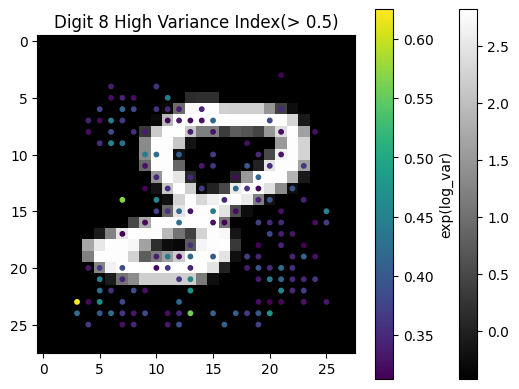

<Figure size 640x480 with 0 Axes>

In [ ]:
# NOTE: The model in VI evaluation
print(f"variance: {log_var.exp().max()}")
highest_var = log_var.exp().max()
k = 0.5
high_var_index = np.where(log_var.view(28, 28).exp() > highest_var * k)
plt.imshow(X.view(28, 28).detach().numpy() , cmap="gray")
plt.colorbar()
# plt.scatter(high_var_index[1], high_var_index[0], s=10, c="red")
# Assume log_var is a tensor and you compute its exponential
exp_values = log_var.view(28, 28).exp()

# Flatten the tensor to 1D for scatter plot
exp_values_flatten = exp_values[high_var_index[0], high_var_index[1]]


# Scatter plot with colors corresponding to exp_values
plt.scatter(
    high_var_index[1], high_var_index[0], s=10, c=exp_values_flatten, cmap="viridis"
)

# Add a colorbar to show the mapping from colors to values
plt.title(f"Digit {input[1]} High Variance Index(> {k})")
plt.colorbar(label="exp(log_var)")
plt.savefig(f"ID {img_id}-Digit {input[1]} high_var_index.png")
plt.show()
plt.clf()

## Start batch experiments

In [ ]:
def saliency_fun(img=img):
  # NOTE: The model in XAI saliency map evaluation
  # Wrap the image in a Variable, set requires_grad=True to compute gradients
  image = torch.autograd.Variable(
      img.clone().unsqueeze(0).unsqueeze(0), requires_grad=True
  )

  # Forward pass
  outputs = model(image)

  # Get the index of the max log-probability
  _, predicted = outputs.max(1)

  # Zero the gradients of the model parameters
  model.zero_grad()

  # Backward pass
  outputs[0, predicted].backward()
  # The saliency map is in the grad of the image
  saliency_map = image.grad.data.abs().max(dim=1)[0]


  # Convert the saliency map from Torch Tensor to numpy array and display it
  saliency_map = saliency_map.numpy()
  plt.imshow(saliency_map[0], cmap=plt.cm.hot)
  # New code to add a colorbar
  plt.title(f"Digit {input[1]} Saliency Map with prediction: {F.softmax(model(image), dim=1).max():.3f}")
  plt.colorbar()
  plt.savefig(f"ID {i}-Digit {input[1]} saliency_map.png")
  plt.show()
  plt.clf()
  print(f"max pixel value: {saliency_map.max()}, min pixel value: {saliency_map.min()}")

In [ ]:
def train_VI(img=img, epochs = 5000):
  # NOTE: Train the VI model
  # HACK: if not specify "predicted" digits, than will attack to certain become another value


  m = VI()
  optim = torch.optim.Adam(m.parameters(), lr=0.005)


  for epoch in range(epochs+1):
      X = img.view(784).clone()
      Y = img.view(784).clone()
      optim.zero_grad()
      y_pred, mu, log_var = m(X)
      # print(f"y_pred shape: {y_pred.shape}")
      # print(f"mu shape: {mu.shape}, log_var shape: {log_var.shape}")
      # Get the index of the max log-probability
      loss = det_loss(y_pred, Y, mu, log_var, model, input[1])

      if epoch % 500 == 0:
          print(f"epoch: {epoch}, loss: {loss}")

      loss.backward()
      optim.step()
  return m

In [ ]:
def plot_surrogate(new_image = new_image):
  model.zero_grad()
  F.softmax(model(new_image), dim=1).max()
  print(
      f"True y = {input[1]}, the highest probability: {F.softmax(model(new_image), dim=1).max():.5f}"
  )
  predicted = torch.argmax(F.softmax(model(new_image), dim=1))
  print(f"New image full model prediction: {F.softmax(model(new_image))}")
  plt.imshow(new_image.squeeze(0).squeeze(0).detach().numpy(), cmap="gray")
  plt.title(f"Digit {predicted} Surrogate model with prediction: {F.softmax(model(new_image), dim=1).max():.3f}")
  plt.colorbar()
  plt.savefig(f"ID {i}-Digit {input[1]} new_image.png")
  plt.show()
  plt.clf()

def plot_high_variance_model(img=img, log_var=log_var ,k = 0.5):
  # NOTE: The model in VI evaluation
  print(f"variance: {log_var.exp().max()}")
  highest_var = log_var.exp().max()

  high_var_index = np.where(log_var.view(28, 28).exp() > highest_var * k)
  plt.imshow(X.view(28, 28).detach().numpy() , cmap="gray")
  plt.colorbar()
  # plt.scatter(high_var_index[1], high_var_index[0], s=10, c="red")
  # Assume log_var is a tensor and you compute its exponential
  exp_values = log_var.view(28, 28).exp()

  # Flatten the tensor to 1D for scatter plot
  exp_values_flatten = exp_values[high_var_index[0], high_var_index[1]]


  # Scatter plot with colors corresponding to exp_values
  plt.scatter(
      high_var_index[1], high_var_index[0], s=10, c=exp_values_flatten, cmap="viridis"
  )

  # Add a colorbar to show the mapping from colors to values
  plt.title(f"Digit {input[1]} High Variance Index(> {k})")
  plt.colorbar(label="exp(log_var)")
  plt.savefig(f"ID {i}-Digit {input[1]} high_var_index.png")
  plt.show()
  plt.clf()

## Run experiments

ID: 0, True y = 7, probability: 1.00000


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1374: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


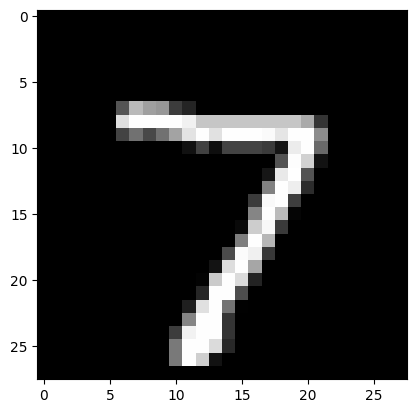

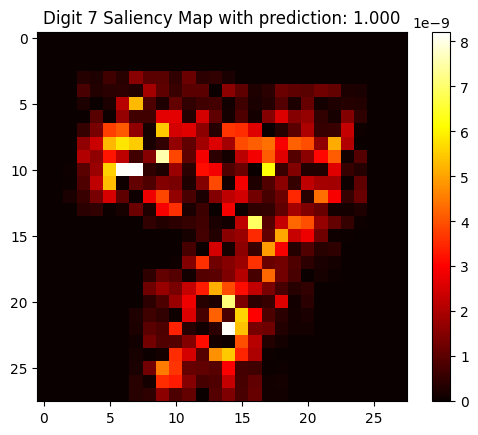

max pixel value: 8.216435531949173e-09, min pixel value: 0.0
epoch: 0, loss: 9.567455291748047
epoch: 500, loss: 1.2656731605529785
epoch: 1000, loss: 1.3422800302505493
epoch: 1500, loss: 0.9457748532295227
epoch: 2000, loss: 0.8147545456886292
epoch: 2500, loss: 0.7482864260673523
epoch: 3000, loss: 0.7117100954055786
epoch: 3500, loss: 0.72271728515625
epoch: 4000, loss: 0.7187467217445374
epoch: 4500, loss: 0.7113152146339417
epoch: 5000, loss: 0.6695167422294617
tensor(0.2296)
True y = 7, the highest probability: 0.99997
New image full model prediction: tensor([[2.6793e-09, 1.0481e-05, 1.9254e-07, 7.9613e-06, 2.8380e-07, 7.2497e-09,
         3.7137e-10, 9.9997e-01, 6.0307e-08, 1.1194e-05]])


<ipython-input-69-933f4a213259>:8: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print(f"New image full model prediction: {F.softmax(model(new_image))}")


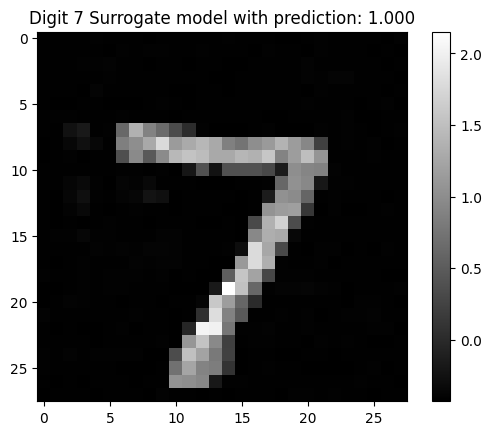

variance: 1.9672200679779053


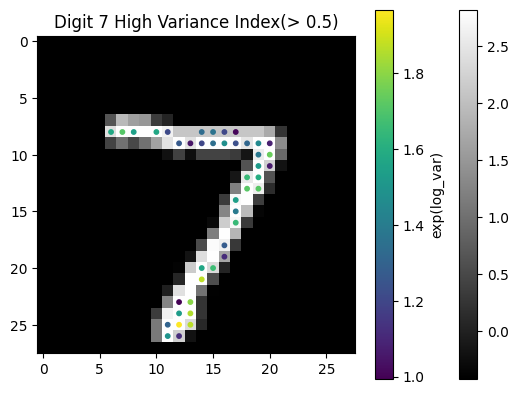

ID: 1, True y = 2, probability: 1.00000


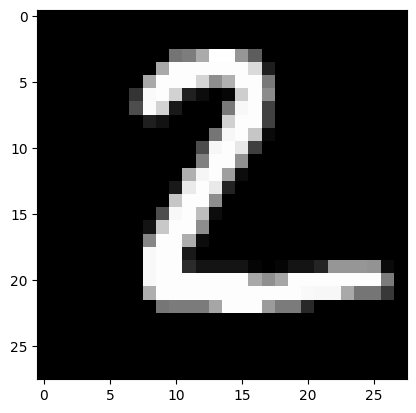

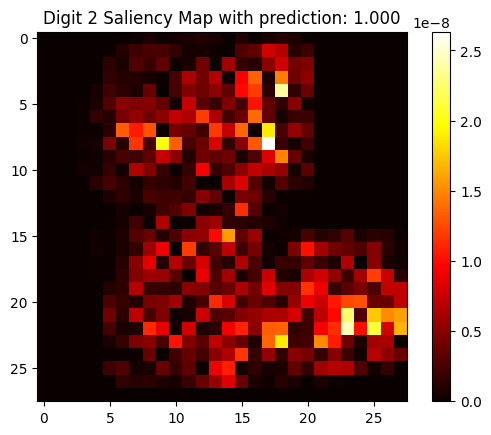

max pixel value: 2.6333452751714503e-08, min pixel value: 0.0
epoch: 0, loss: 1.5667672157287598
epoch: 500, loss: 1.0888752937316895
epoch: 1000, loss: 0.8221335411071777
epoch: 1500, loss: 0.8921738266944885
epoch: 2000, loss: 0.7859134078025818
epoch: 2500, loss: 0.7975831031799316
epoch: 3000, loss: 0.8581616282463074
epoch: 3500, loss: 0.7839828133583069
epoch: 4000, loss: 0.8242090940475464
epoch: 4500, loss: 0.795904815196991
epoch: 5000, loss: 0.8147343397140503
tensor(0.2621)
True y = 2, the highest probability: 0.99994
New image full model prediction: tensor([[6.7078e-07, 5.4771e-05, 9.9994e-01, 9.6879e-08, 1.7514e-08, 8.8007e-11,
         1.1092e-07, 1.9016e-09, 2.4320e-08, 1.5505e-09]])


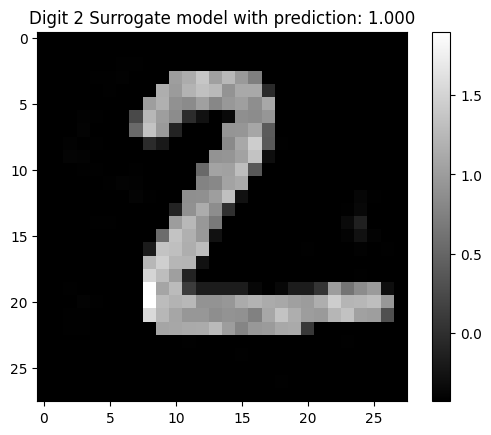

variance: 3.025263786315918


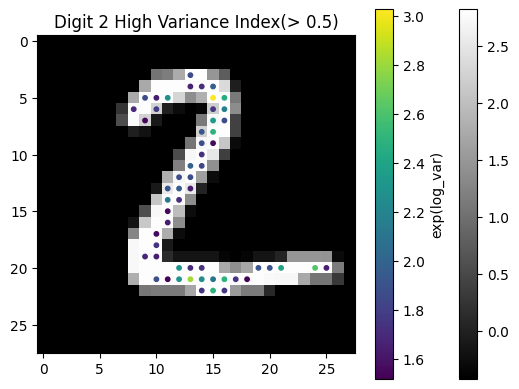

ID: 2, True y = 1, probability: 1.00000


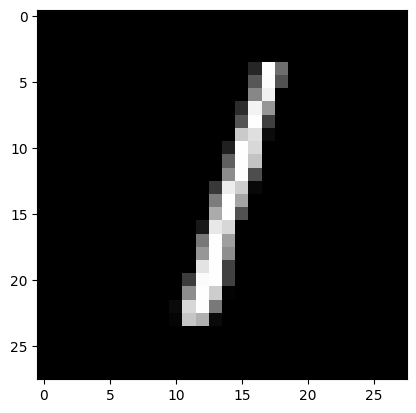

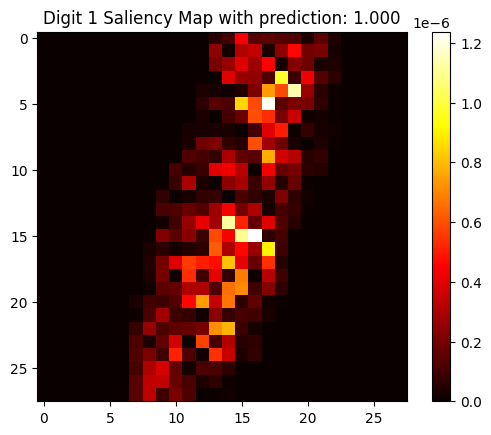

max pixel value: 1.2373074014249141e-06, min pixel value: 0.0
epoch: 0, loss: 7.460437774658203
epoch: 500, loss: 1.1423383951187134
epoch: 1000, loss: 0.844994843006134
epoch: 1500, loss: 0.8440971970558167
epoch: 2000, loss: 0.652376651763916
epoch: 2500, loss: 0.6064342856407166
epoch: 3000, loss: 0.6494460701942444
epoch: 3500, loss: 0.6443628072738647
epoch: 4000, loss: 0.6119030117988586
epoch: 4500, loss: 0.5863485336303711
epoch: 5000, loss: 0.6351127028465271
tensor(0.1520)
True y = 1, the highest probability: 0.99996
New image full model prediction: tensor([[4.2055e-08, 9.9996e-01, 2.6624e-06, 1.1656e-08, 6.1469e-06, 8.8976e-07,
         3.6586e-06, 2.9758e-05, 1.0893e-06, 3.0677e-07]])


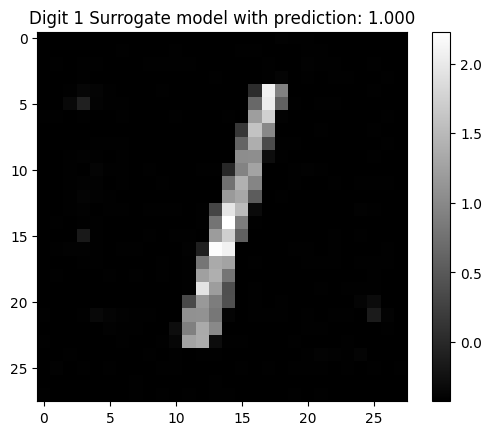

variance: 1.7949738502502441


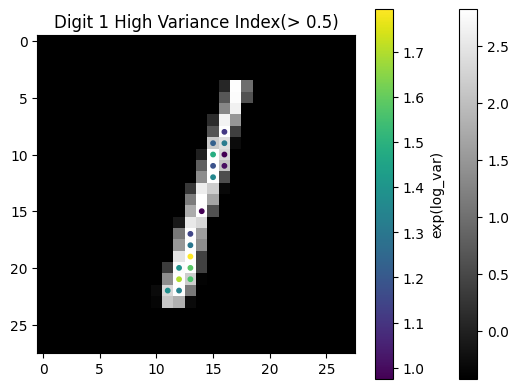

ID: 3, True y = 0, probability: 1.00000


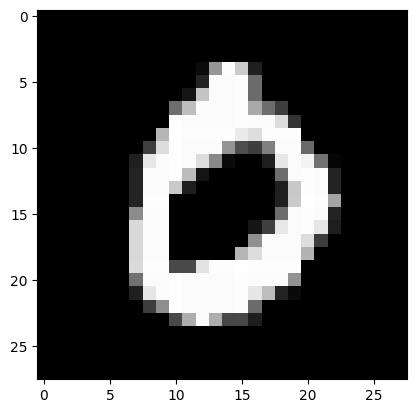

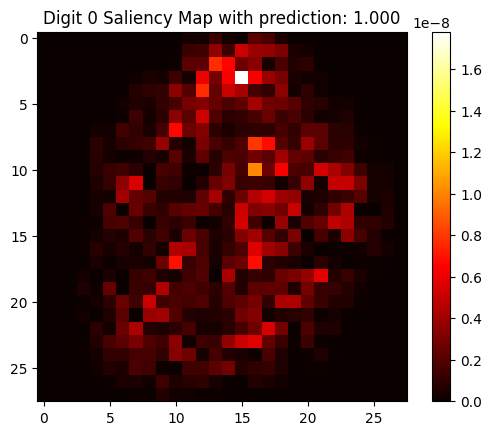

max pixel value: 1.7814503650015467e-08, min pixel value: 0.0
epoch: 0, loss: 8.998083114624023
epoch: 500, loss: 1.7988581657409668
epoch: 1000, loss: 1.490419626235962
epoch: 1500, loss: 1.418891429901123
epoch: 2000, loss: 1.2560319900512695
epoch: 2500, loss: 1.2322453260421753
epoch: 3000, loss: 1.1902512311935425
epoch: 3500, loss: 1.1860530376434326
epoch: 4000, loss: 1.0721083879470825
epoch: 4500, loss: 1.089390754699707
epoch: 5000, loss: 1.055815577507019
tensor(0.5663)
True y = 0, the highest probability: 1.00000
New image full model prediction: tensor([[1.0000e+00, 1.3103e-09, 7.5649e-09, 5.9541e-10, 5.8650e-11, 7.2970e-09,
         7.2773e-07, 2.1283e-09, 9.5212e-08, 7.0158e-10]])


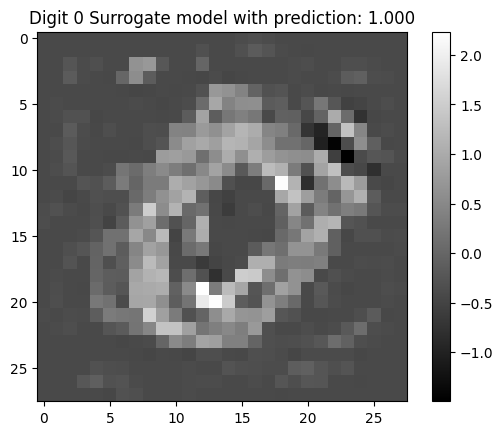

variance: 5.671127796173096


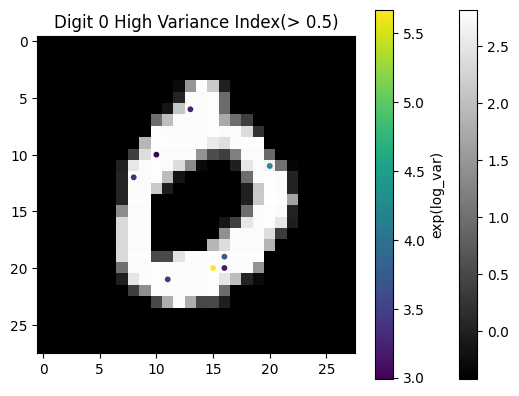

ID: 4, True y = 4, probability: 1.00000


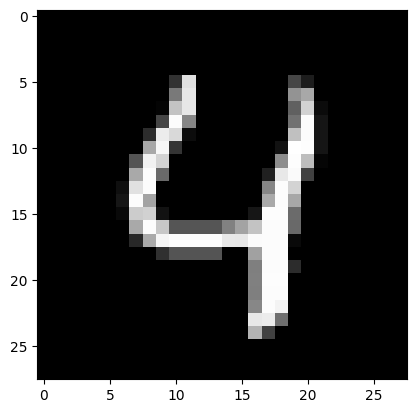

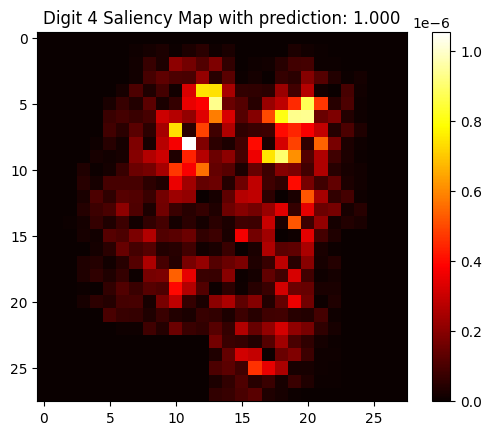

max pixel value: 1.055023972185154e-06, min pixel value: 0.0
epoch: 0, loss: 5.218188762664795
epoch: 500, loss: 1.216002345085144
epoch: 1000, loss: 0.9406535625457764
epoch: 1500, loss: 0.8474092483520508
epoch: 2000, loss: 0.7487991452217102
epoch: 2500, loss: 0.7498846054077148
epoch: 3000, loss: 0.7063397765159607
epoch: 3500, loss: 0.6941195130348206
epoch: 4000, loss: 0.7391119003295898
epoch: 4500, loss: 0.6352327466011047
epoch: 5000, loss: 0.7395920157432556
tensor(0.1882)
True y = 4, the highest probability: 0.99997
New image full model prediction: tensor([[1.7960e-09, 1.0524e-06, 7.4055e-08, 1.9875e-10, 9.9997e-01, 1.1391e-08,
         1.7268e-08, 3.3299e-08, 1.0732e-06, 2.6923e-05]])


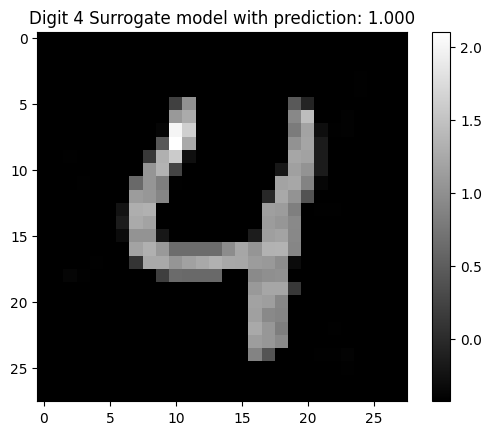

variance: 2.2559075355529785


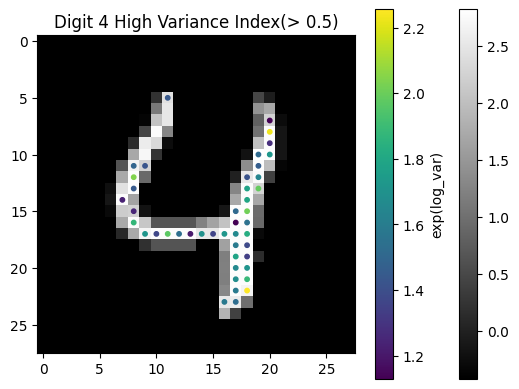

ID: 5, True y = 1, probability: 0.99998


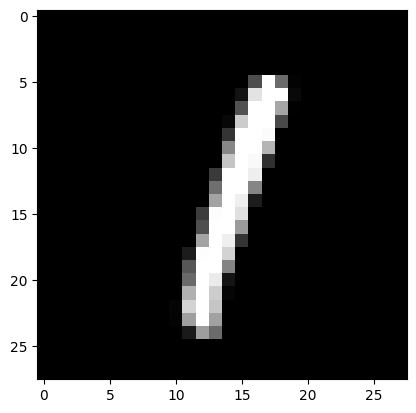

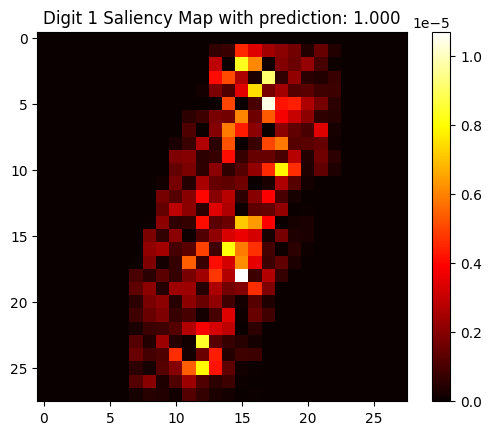

max pixel value: 1.0701191058615223e-05, min pixel value: 0.0
epoch: 0, loss: 8.83810043334961
epoch: 500, loss: 1.1838138103485107
epoch: 1000, loss: 0.964272141456604
epoch: 1500, loss: 0.8287979364395142
epoch: 2000, loss: 0.7207578420639038
epoch: 2500, loss: 0.6892540454864502
epoch: 3000, loss: 0.6973268985748291
epoch: 3500, loss: 0.6905417442321777
epoch: 4000, loss: 0.6309574842453003
epoch: 4500, loss: 0.6359835863113403
epoch: 5000, loss: 0.7049893736839294
tensor(0.1727)
True y = 1, the highest probability: 0.99992
New image full model prediction: tensor([[1.0674e-08, 9.9992e-01, 4.9286e-07, 4.3096e-09, 8.7744e-06, 2.7697e-07,
         9.8197e-07, 6.3438e-05, 1.2115e-06, 2.9186e-07]])


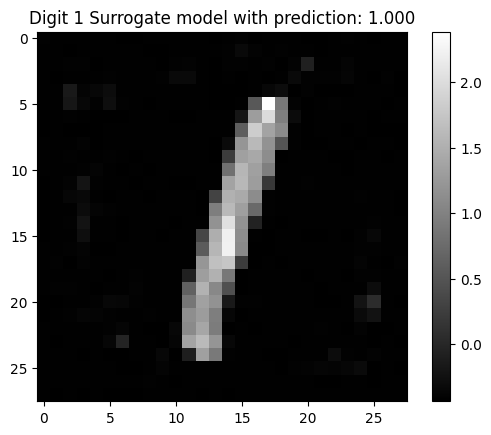

variance: 1.5525749921798706


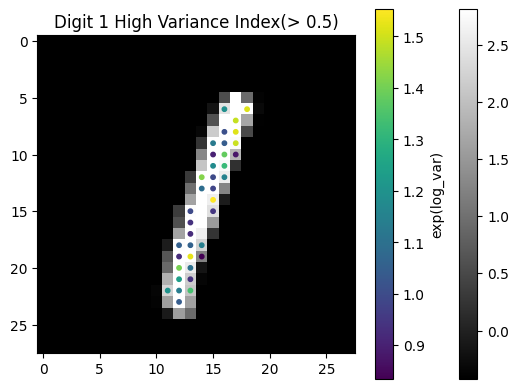

ID: 6, True y = 4, probability: 0.99991


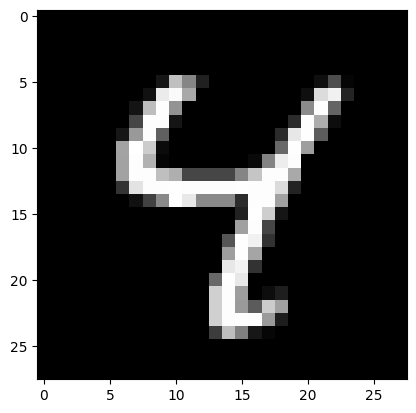

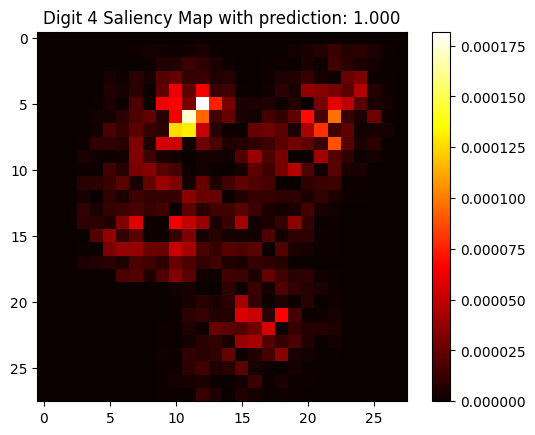

max pixel value: 0.0001818123710108921, min pixel value: 0.0
epoch: 0, loss: 9.863777160644531
epoch: 500, loss: 1.3301376104354858
epoch: 1000, loss: 1.0302811861038208
epoch: 1500, loss: 0.8744938969612122
epoch: 2000, loss: 0.7718924880027771
epoch: 2500, loss: 0.7761637568473816
epoch: 3000, loss: 0.7149015665054321
epoch: 3500, loss: 0.788445770740509
epoch: 4000, loss: 0.7361205220222473
epoch: 4500, loss: 0.7203221917152405
epoch: 5000, loss: 0.7581877708435059
tensor(0.3002)
True y = 4, the highest probability: 0.99998
New image full model prediction: tensor([[3.3465e-12, 1.8836e-05, 2.8514e-09, 1.0372e-11, 9.9998e-01, 8.6555e-09,
         4.9678e-09, 9.0883e-09, 4.8165e-06, 6.1387e-07]])


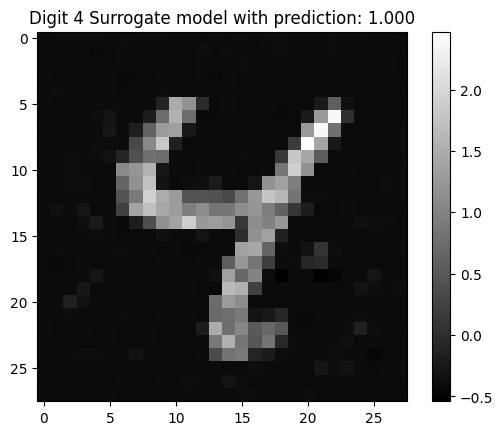

variance: 3.743528127670288


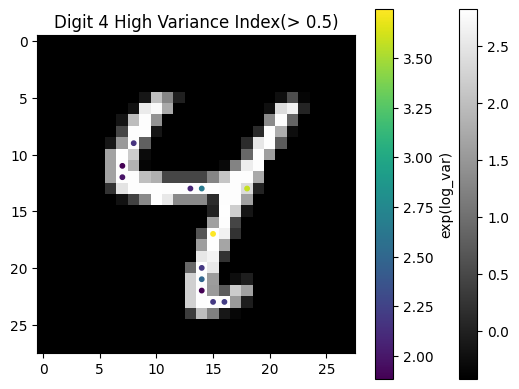

ID: 7, True y = 9, probability: 1.00000


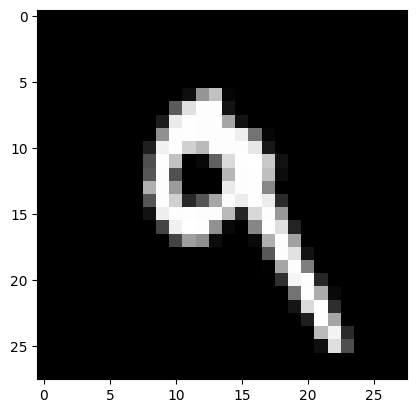

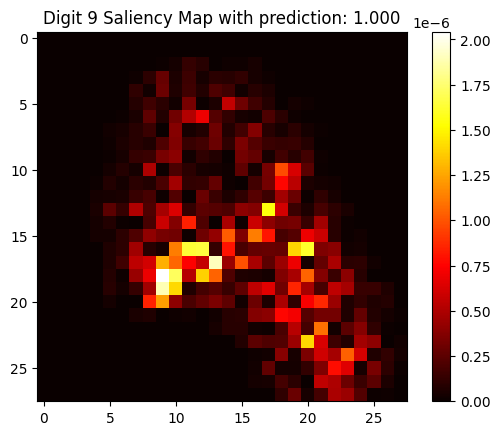

max pixel value: 2.042636879195925e-06, min pixel value: 0.0
epoch: 0, loss: 11.885001182556152
epoch: 500, loss: 1.3947434425354004
epoch: 1000, loss: 1.0505865812301636
epoch: 1500, loss: 0.9188993573188782
epoch: 2000, loss: 0.8367125988006592
epoch: 2500, loss: 0.7826085090637207
epoch: 3000, loss: 0.7324800491333008
epoch: 3500, loss: 0.7184436321258545
epoch: 4000, loss: 1.405838966369629
epoch: 4500, loss: 0.7719639539718628
epoch: 5000, loss: 0.6728562116622925
tensor(0.2424)
True y = 9, the highest probability: 0.99999
New image full model prediction: tensor([[1.2529e-08, 2.1210e-10, 3.9704e-09, 1.5252e-07, 5.7142e-06, 6.1037e-07,
         3.6937e-12, 4.7555e-09, 6.3967e-06, 9.9999e-01]])


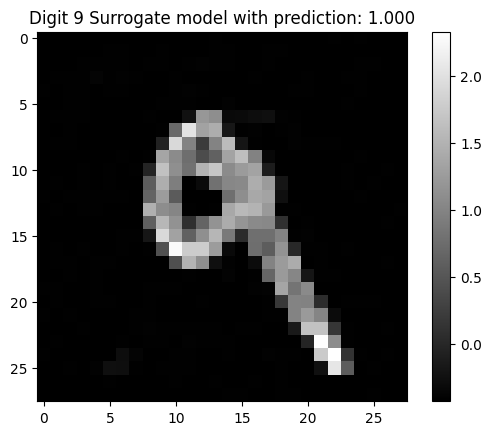

variance: 2.732243299484253


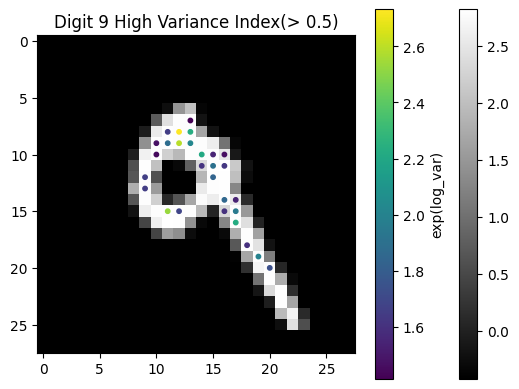

ID: 8, True y = 5, probability: 0.95626


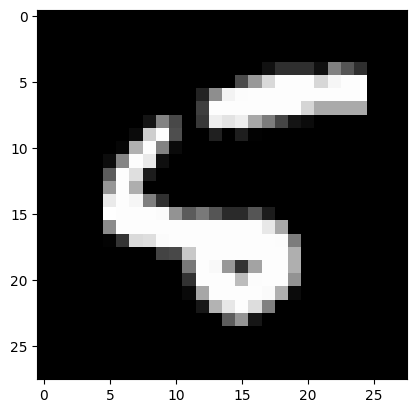

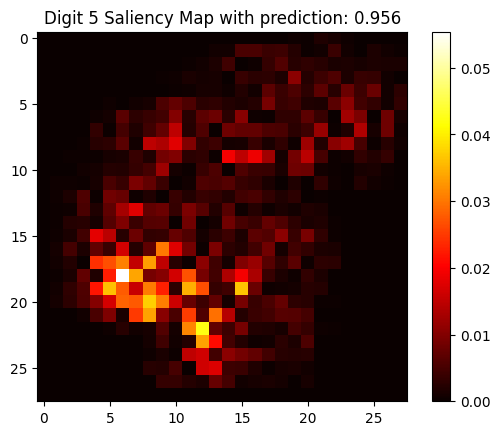

max pixel value: 0.05541253462433815, min pixel value: 0.0
epoch: 0, loss: 8.280309677124023
epoch: 500, loss: 1.3668127059936523
epoch: 1000, loss: 1.228757619857788
epoch: 1500, loss: 1.122373104095459
epoch: 2000, loss: 1.1076757907867432
epoch: 2500, loss: 1.0657585859298706
epoch: 3000, loss: 1.0164648294448853
epoch: 3500, loss: 0.9781288504600525
epoch: 4000, loss: 0.9195403456687927
epoch: 4500, loss: 0.9629343152046204
epoch: 5000, loss: 0.9385497570037842
tensor(0.6010)
True y = 5, the highest probability: 1.00000
New image full model prediction: tensor([[2.3537e-13, 6.6124e-15, 6.6424e-19, 5.1974e-12, 2.0097e-15, 1.0000e+00,
         8.4180e-10, 2.1055e-14, 9.1406e-12, 1.0346e-10]])


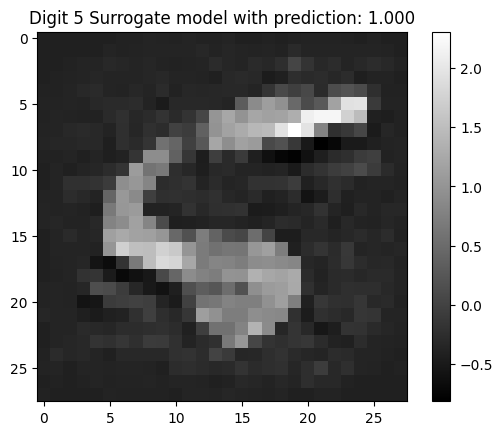

variance: 2.5928640365600586


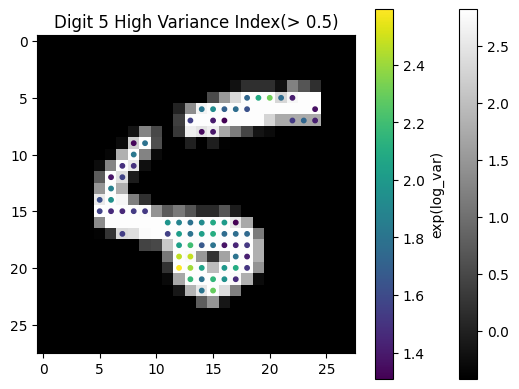

ID: 9, True y = 9, probability: 0.99988


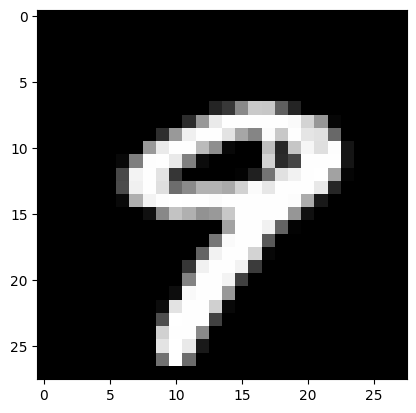

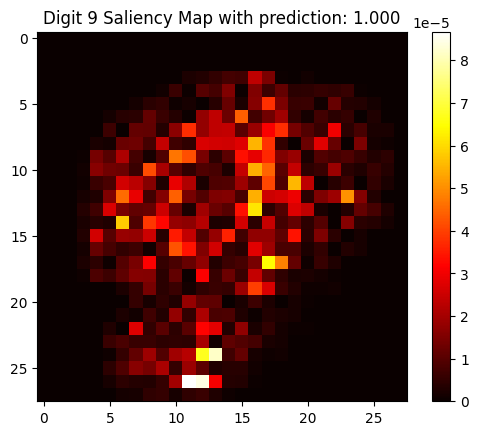

max pixel value: 8.672514377394691e-05, min pixel value: 0.0
epoch: 0, loss: 9.590764045715332
epoch: 500, loss: 1.3112901449203491
epoch: 1000, loss: 1.0642030239105225
epoch: 1500, loss: 0.9627149105072021
epoch: 2000, loss: 0.8848464488983154
epoch: 2500, loss: 0.8860185742378235
epoch: 3000, loss: 0.8531864881515503
epoch: 3500, loss: 0.8502700328826904
epoch: 4000, loss: 0.8936679363250732
epoch: 4500, loss: 0.800372302532196
epoch: 5000, loss: 0.7698827385902405
tensor(0.2954)
True y = 9, the highest probability: 1.00000
New image full model prediction: tensor([[5.8066e-12, 4.2609e-11, 1.9141e-13, 1.8170e-09, 2.2331e-06, 3.8967e-08,
         1.2118e-15, 1.8555e-08, 1.5070e-07, 1.0000e+00]])


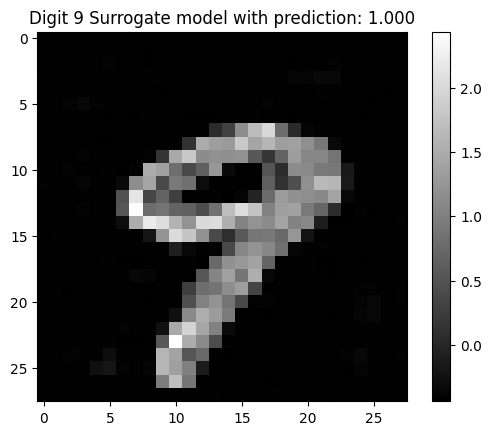

variance: 2.8029396533966064


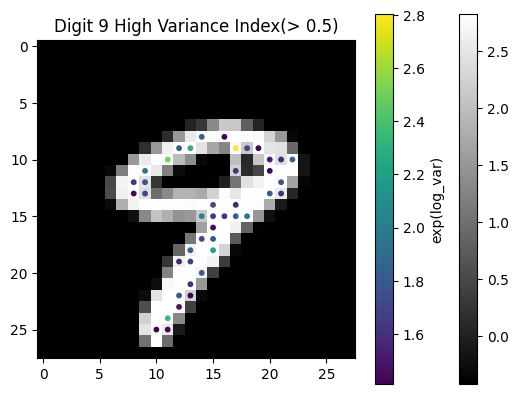

ID: 10, True y = 0, probability: 1.00000


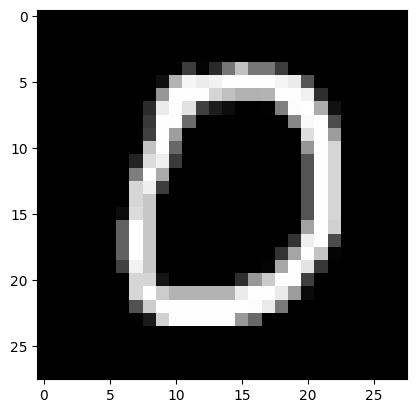

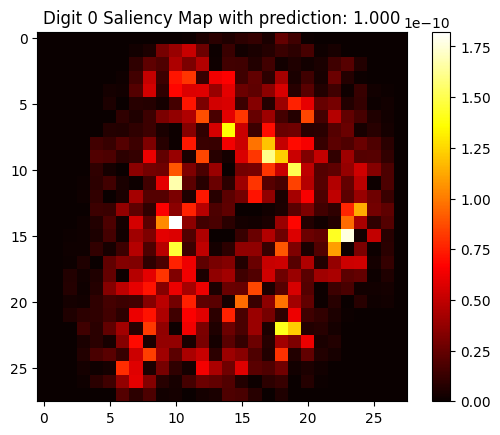

max pixel value: 1.8229519282986217e-10, min pixel value: 0.0
epoch: 0, loss: 13.460185050964355
epoch: 500, loss: 1.5060838460922241
epoch: 1000, loss: 1.2190263271331787
epoch: 1500, loss: 1.0695747137069702
epoch: 2000, loss: 0.9906848073005676
epoch: 2500, loss: 0.8318213820457458
epoch: 3000, loss: 0.8666308522224426
epoch: 3500, loss: 0.7842649221420288
epoch: 4000, loss: 0.8313015699386597
epoch: 4500, loss: 0.8287990093231201
epoch: 5000, loss: 0.7909846901893616
tensor(0.2734)
True y = 0, the highest probability: 1.00000
New image full model prediction: tensor([[1.0000e+00, 1.4963e-07, 1.6681e-09, 3.3198e-10, 1.9571e-11, 5.3369e-10,
         1.6797e-08, 1.2597e-08, 7.1267e-08, 4.8424e-08]])


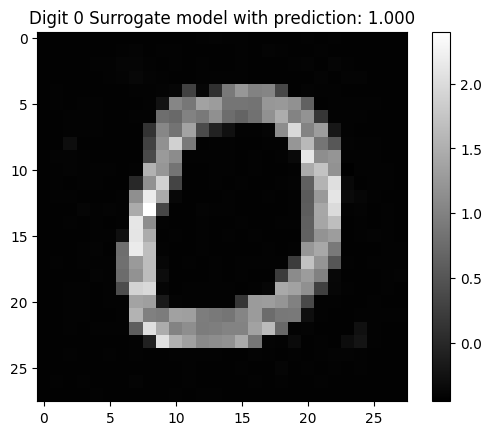

variance: 2.6477317810058594


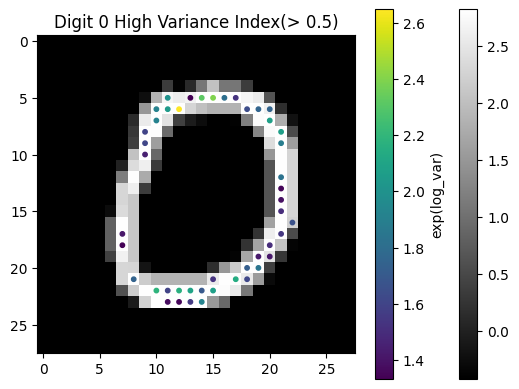

ID: 11, True y = 6, probability: 1.00000


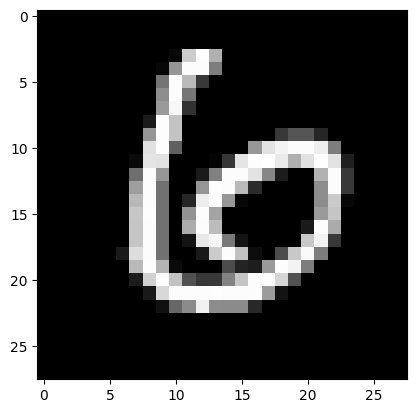

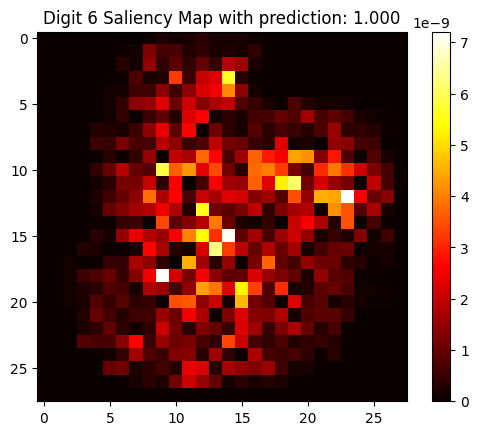

max pixel value: 7.205634311446829e-09, min pixel value: 0.0
epoch: 0, loss: 5.30215311050415
epoch: 500, loss: 1.268999695777893
epoch: 1000, loss: 0.9439600110054016
epoch: 1500, loss: 0.7914674878120422
epoch: 2000, loss: 0.7754938006401062
epoch: 2500, loss: 0.7643428444862366
epoch: 3000, loss: 0.8134307265281677
epoch: 3500, loss: 0.736503005027771
epoch: 4000, loss: 0.8141608238220215
epoch: 4500, loss: 0.8067524433135986
epoch: 5000, loss: 0.7549811601638794
tensor(0.2702)
True y = 6, the highest probability: 1.00000
New image full model prediction: tensor([[3.6053e-06, 4.1725e-10, 1.4129e-11, 1.8984e-12, 1.5729e-08, 2.9293e-08,
         1.0000e+00, 2.3097e-12, 7.2284e-09, 2.2979e-11]])


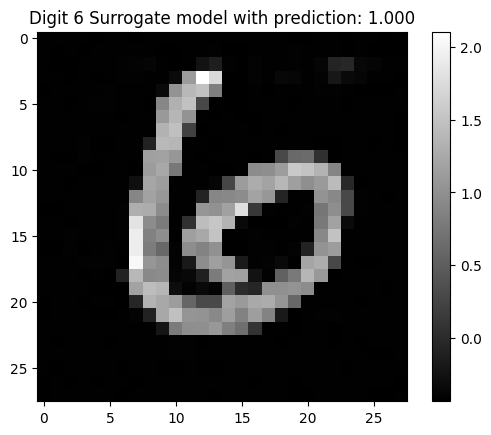

variance: 2.7009644508361816


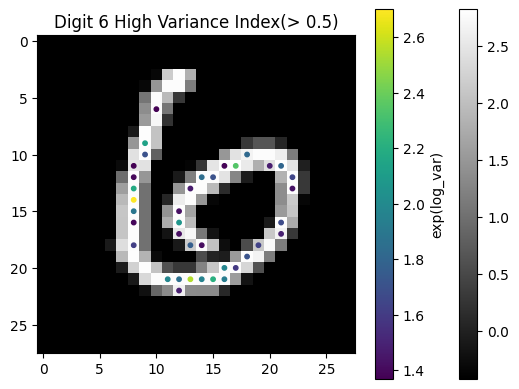

ID: 12, True y = 9, probability: 0.99996


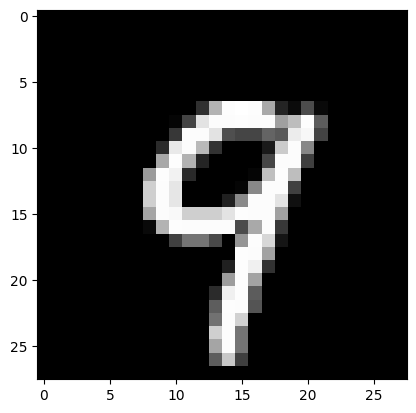

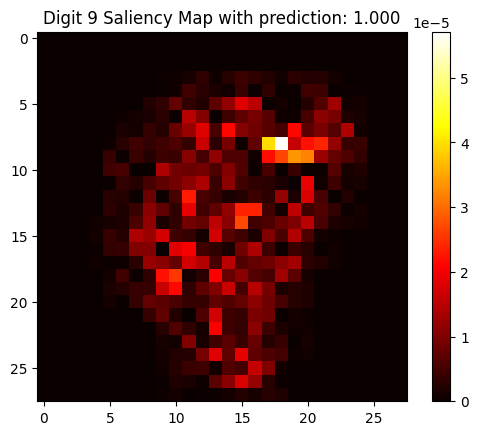

max pixel value: 5.711349513148889e-05, min pixel value: 0.0
epoch: 0, loss: 7.771096229553223
epoch: 500, loss: 1.186435580253601
epoch: 1000, loss: 1.0839433670043945
epoch: 1500, loss: 0.877442479133606
epoch: 2000, loss: 0.8468020558357239
epoch: 2500, loss: 0.7765287160873413
epoch: 3000, loss: 0.7700849175453186
epoch: 3500, loss: 0.7338389754295349
epoch: 4000, loss: 0.7310699820518494
epoch: 4500, loss: 0.7452690005302429
epoch: 5000, loss: 0.6990824937820435
tensor(0.2090)
True y = 9, the highest probability: 0.99999
New image full model prediction: tensor([[1.6815e-10, 2.4349e-10, 3.7489e-12, 6.4687e-10, 7.9753e-06, 2.8526e-08,
         8.4787e-14, 1.1646e-08, 3.7058e-07, 9.9999e-01]])


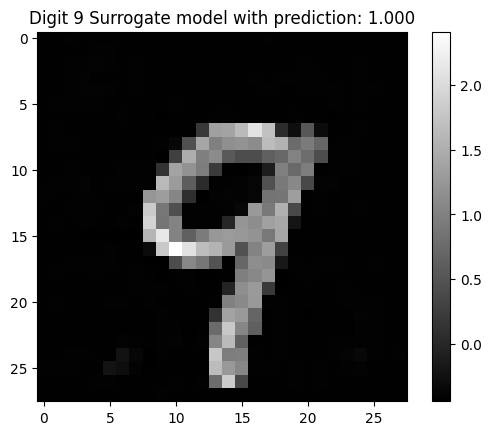

variance: 2.101492404937744


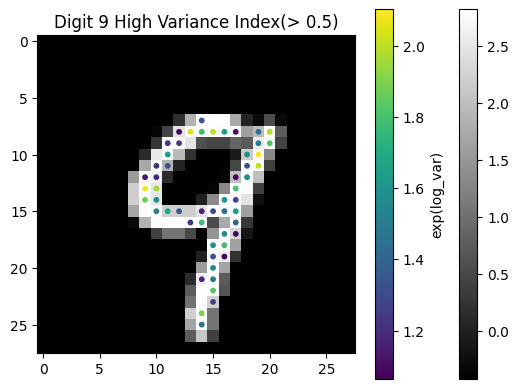

ID: 13, True y = 0, probability: 1.00000


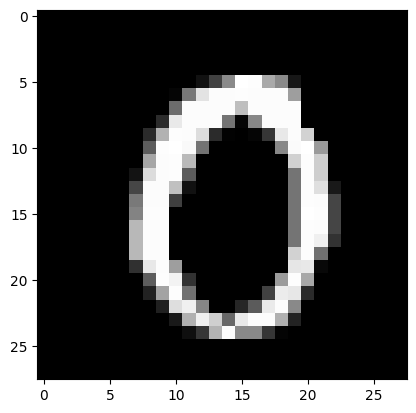

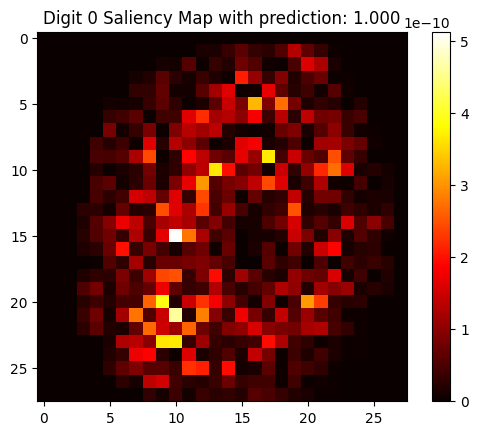

max pixel value: 5.125609936484921e-10, min pixel value: 0.0
epoch: 0, loss: 6.019301891326904
epoch: 500, loss: 1.5859370231628418
epoch: 1000, loss: 1.1802715063095093
epoch: 1500, loss: 0.9896273016929626
epoch: 2000, loss: 0.908236026763916
epoch: 2500, loss: 0.7526336908340454
epoch: 3000, loss: 0.7842203378677368
epoch: 3500, loss: 0.8438717722892761
epoch: 4000, loss: 0.8312233686447144
epoch: 4500, loss: 0.8308327198028564
epoch: 5000, loss: 0.841028094291687
tensor(0.3137)
True y = 0, the highest probability: 1.00000
New image full model prediction: tensor([[1.0000e+00, 4.3104e-07, 2.6400e-09, 7.5125e-10, 7.1378e-10, 2.6633e-09,
         2.2539e-07, 1.1260e-08, 1.5207e-07, 1.1848e-07]])


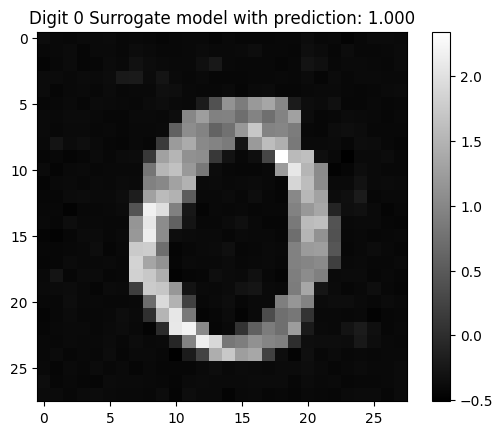

variance: 3.4748902320861816


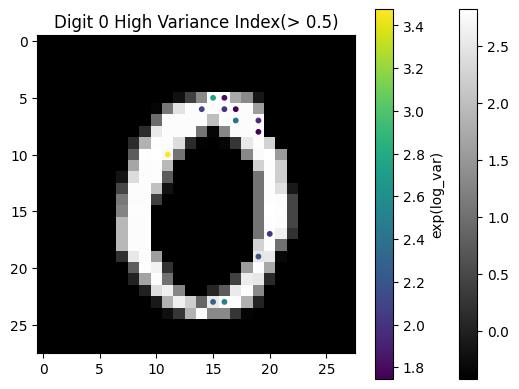

ID: 14, True y = 1, probability: 1.00000


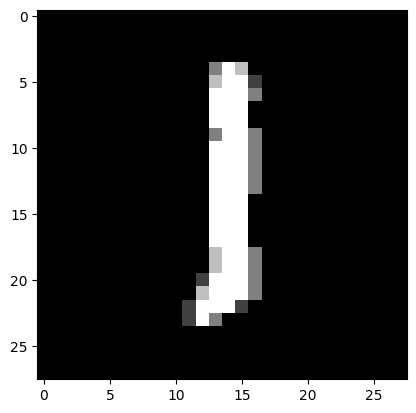

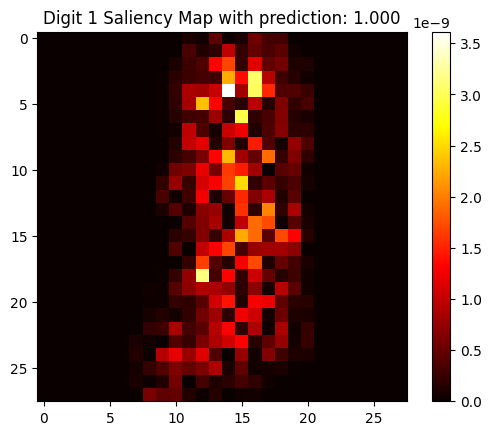

max pixel value: 3.6136760250826683e-09, min pixel value: 0.0
epoch: 0, loss: 3.394416570663452
epoch: 500, loss: 1.0670925378799438
epoch: 1000, loss: 0.782447099685669
epoch: 1500, loss: 0.7363645434379578
epoch: 2000, loss: 0.7433292865753174
epoch: 2500, loss: 0.6869619488716125
epoch: 3000, loss: 0.7365889549255371
epoch: 3500, loss: 0.7239066958427429
epoch: 4000, loss: 0.7306402325630188
epoch: 4500, loss: 0.7681336402893066
epoch: 5000, loss: 0.7054696083068848
tensor(0.1704)
True y = 1, the highest probability: 0.99999
New image full model prediction: tensor([[2.3764e-08, 9.9999e-01, 2.0960e-07, 4.4671e-09, 3.6955e-06, 2.3671e-07,
         6.9554e-08, 2.7643e-07, 4.7571e-07, 4.4483e-08]])


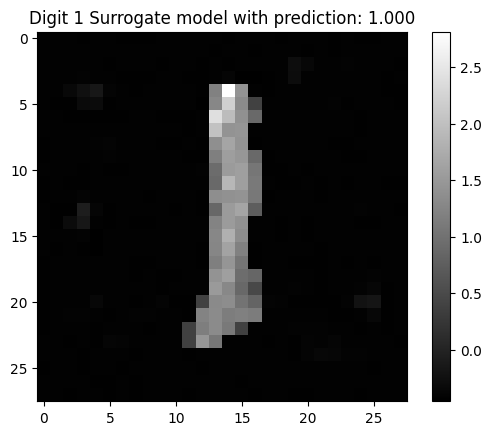

variance: 2.2323405742645264


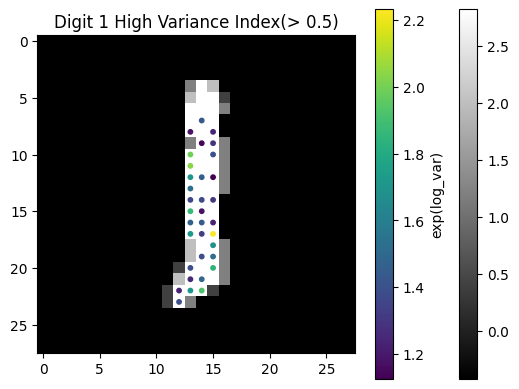

ID: 15, True y = 5, probability: 1.00000


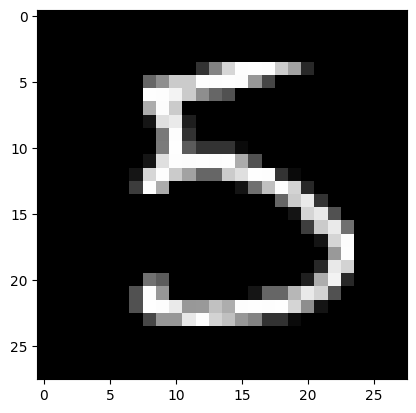

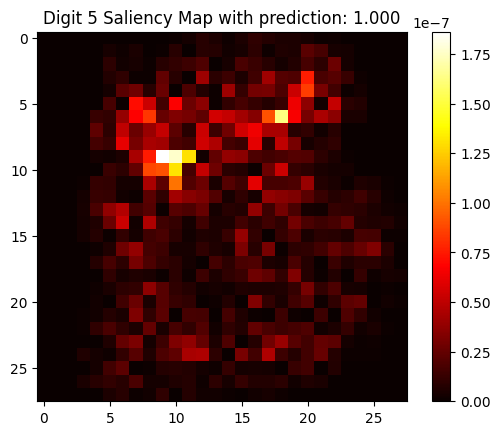

max pixel value: 1.8627154929617973e-07, min pixel value: 0.0
epoch: 0, loss: 12.330854415893555
epoch: 500, loss: 1.567732810974121
epoch: 1000, loss: 1.1170591115951538
epoch: 1500, loss: 0.8382351398468018
epoch: 2000, loss: 0.7497347593307495
epoch: 2500, loss: 0.7255099415779114
epoch: 3000, loss: 0.7059870958328247
epoch: 3500, loss: 0.7517775893211365
epoch: 4000, loss: 0.7669615745544434
epoch: 4500, loss: 0.699123203754425
epoch: 5000, loss: 0.6341372728347778
tensor(0.1758)
True y = 5, the highest probability: 0.99999
New image full model prediction: tensor([[1.5408e-09, 1.0930e-08, 6.0053e-11, 6.5057e-06, 8.7615e-11, 9.9999e-01,
         1.4785e-06, 8.3106e-09, 1.5002e-07, 5.2572e-08]])


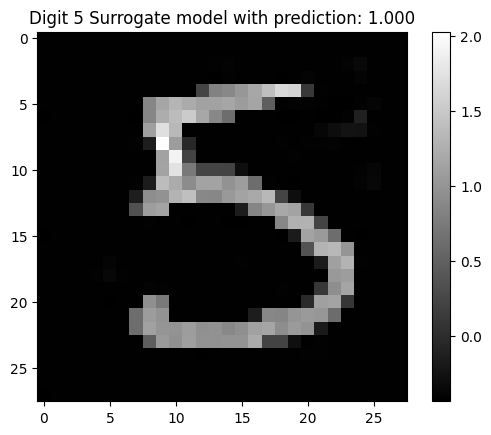

variance: 2.2863781452178955


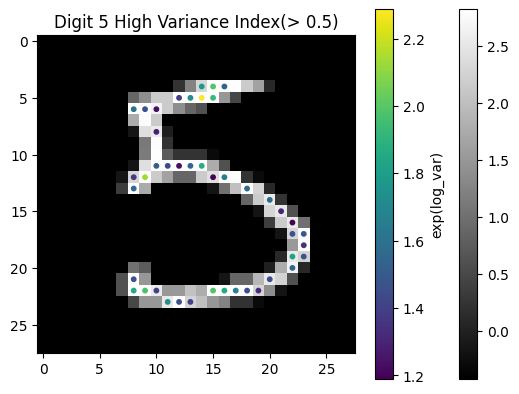

ID: 16, True y = 9, probability: 1.00000


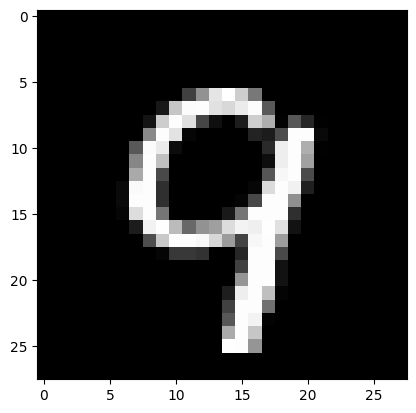

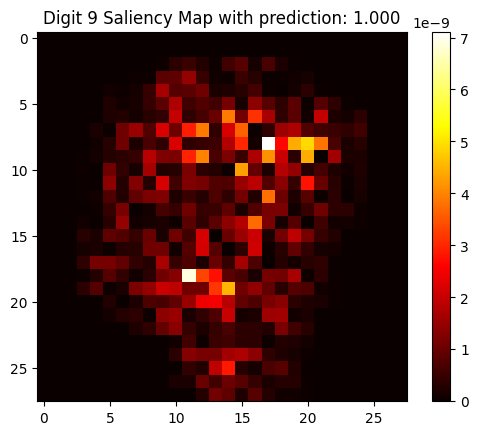

max pixel value: 7.11242353901298e-09, min pixel value: 0.0
epoch: 0, loss: 10.927681922912598
epoch: 500, loss: 1.476827621459961
epoch: 1000, loss: 1.2528355121612549
epoch: 1500, loss: 1.0920335054397583
epoch: 2000, loss: 1.0795363187789917
epoch: 2500, loss: 1.028012990951538
epoch: 3000, loss: 0.9697601199150085
epoch: 3500, loss: 0.942688524723053
epoch: 4000, loss: 0.8955233097076416
epoch: 4500, loss: 0.8789029717445374
epoch: 5000, loss: 0.8499606251716614
tensor(0.5058)
True y = 9, the highest probability: 1.00000
New image full model prediction: tensor([[3.1196e-14, 1.1045e-15, 1.8807e-16, 3.4879e-13, 1.1861e-09, 2.7099e-12,
         2.0370e-20, 2.0128e-11, 8.2613e-11, 1.0000e+00]])


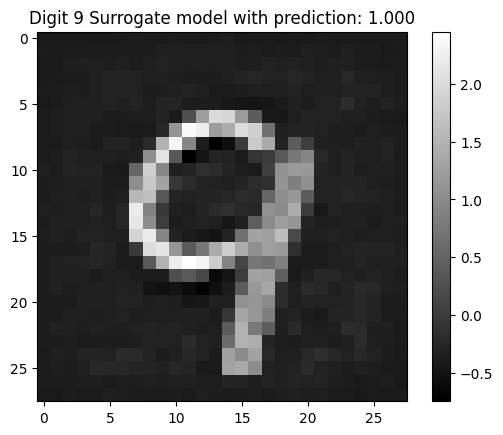

variance: 2.0376932621002197


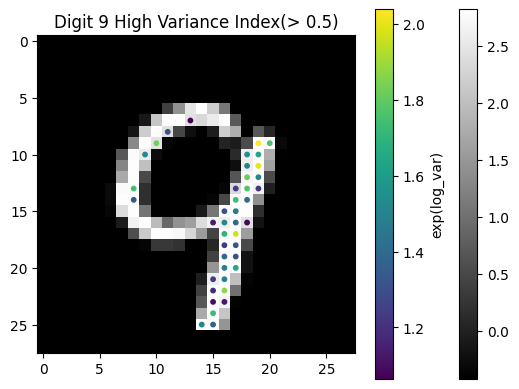

ID: 17, True y = 7, probability: 1.00000


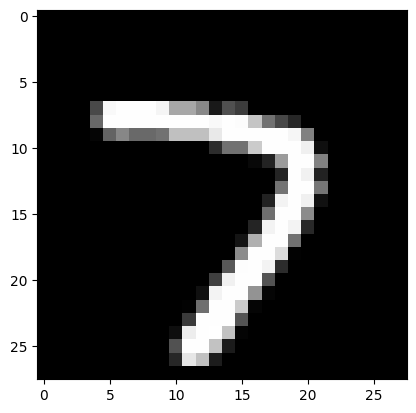

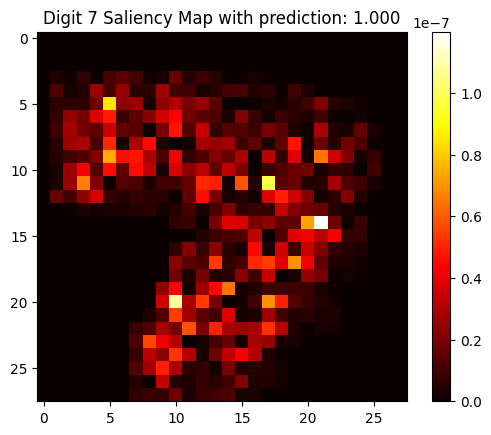

max pixel value: 1.1990749726464855e-07, min pixel value: 0.0
epoch: 0, loss: 4.0170769691467285
epoch: 500, loss: 1.2952197790145874
epoch: 1000, loss: 1.2466228008270264
epoch: 1500, loss: 1.1072955131530762
epoch: 2000, loss: 1.106826901435852
epoch: 2500, loss: 1.0214948654174805
epoch: 3000, loss: 0.958662748336792
epoch: 3500, loss: 0.943284273147583
epoch: 4000, loss: 0.9531051516532898
epoch: 4500, loss: 0.908660352230072
epoch: 5000, loss: 0.847558319568634
tensor(0.5347)
True y = 7, the highest probability: 1.00000
New image full model prediction: tensor([[2.1666e-13, 7.3804e-09, 1.7792e-11, 1.4401e-09, 2.1884e-11, 1.3458e-13,
         9.0348e-16, 1.0000e+00, 1.1674e-12, 5.8239e-10]])


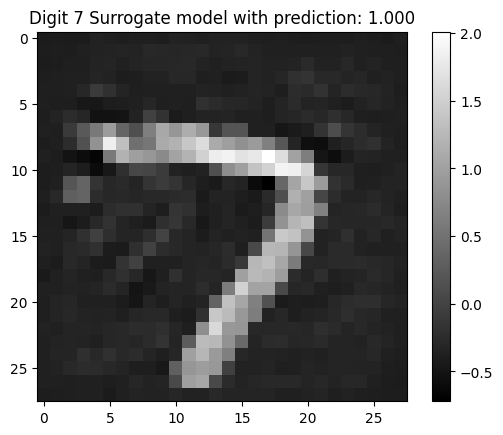

variance: 2.525110960006714


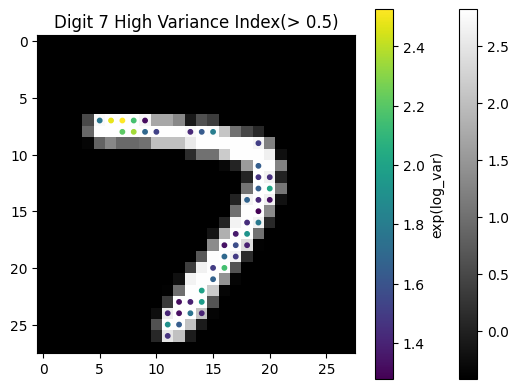

ID: 18, True y = 3, probability: 0.99968


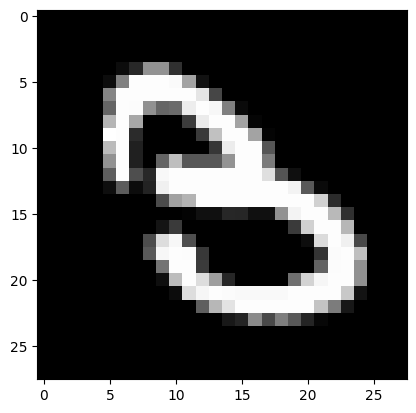

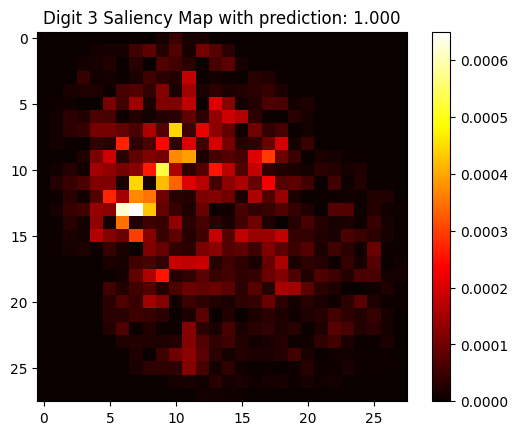

max pixel value: 0.000649771245662123, min pixel value: 0.0
epoch: 0, loss: 1.9178043603897095
epoch: 500, loss: 1.1706368923187256
epoch: 1000, loss: 1.1261945962905884
epoch: 1500, loss: 1.0163068771362305
epoch: 2000, loss: 0.9834012985229492
epoch: 2500, loss: 0.8956575989723206
epoch: 3000, loss: 0.9080736041069031
epoch: 3500, loss: 1.0048508644104004
epoch: 4000, loss: 0.8983876705169678
epoch: 4500, loss: 0.8938566446304321
epoch: 5000, loss: 0.8326746225357056
tensor(0.3733)
True y = 3, the highest probability: 0.99942
New image full model prediction: tensor([[3.5782e-07, 5.6172e-07, 8.4919e-05, 9.9942e-01, 5.6213e-08, 2.5010e-04,
         2.3408e-07, 2.2625e-04, 1.2036e-05, 3.9093e-06]])


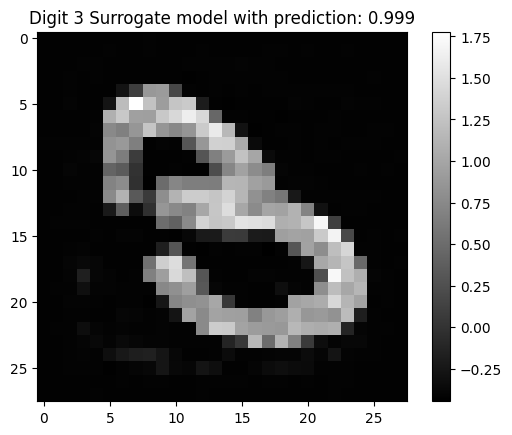

variance: 2.5235700607299805


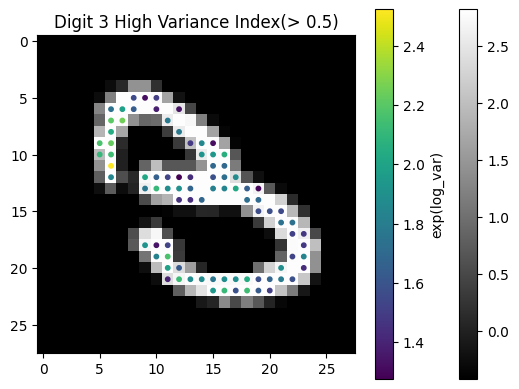

ID: 19, True y = 4, probability: 1.00000


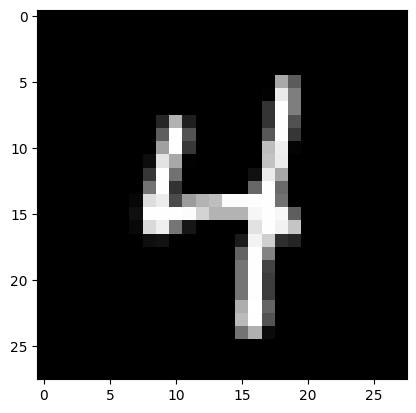

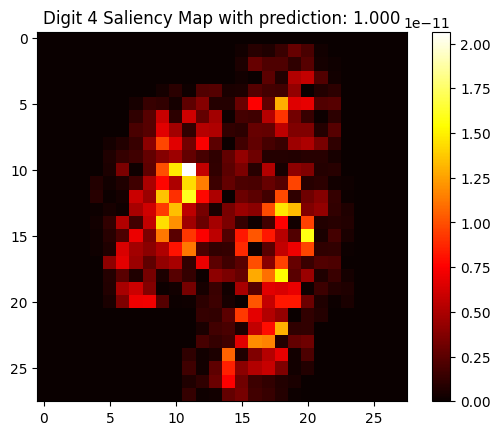

max pixel value: 2.0664268907122363e-11, min pixel value: 0.0
epoch: 0, loss: 3.4915683269500732
epoch: 500, loss: 1.308903694152832
epoch: 1000, loss: 1.2391194105148315
epoch: 1500, loss: 1.094224214553833
epoch: 2000, loss: 0.9759414792060852
epoch: 2500, loss: 0.9149320125579834
epoch: 3000, loss: 0.9124768376350403
epoch: 3500, loss: 0.8933865427970886
epoch: 4000, loss: 0.8446381092071533
epoch: 4500, loss: 0.8057230114936829
epoch: 5000, loss: 0.788398802280426
tensor(0.4761)
True y = 4, the highest probability: 1.00000
New image full model prediction: tensor([[2.5898e-13, 1.1201e-07, 6.7700e-10, 6.6880e-13, 1.0000e+00, 2.6361e-10,
         4.3573e-11, 1.8650e-08, 9.6223e-09, 1.0074e-07]])


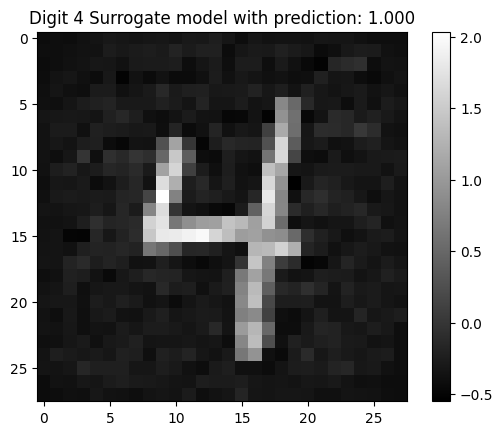

variance: 1.7651422023773193


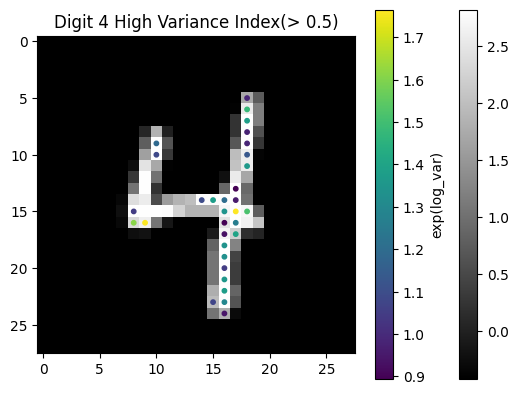

<Figure size 640x480 with 0 Axes>

In [ ]:
model.eval()
for i in range(20):
  model.zero_grad()
  img_id = i
  input = testset[img_id]
  img = input[0].squeeze(0).clone()
  # img = transform(img)
  plt.imshow(img, cmap="gray")
  plt.savefig(f"ID {i}-Digit {input[1]} original_image.png")
  print(
      f"ID: {img_id}, True y = {input[1]}, probability: {F.softmax(model(input[0].unsqueeze(0)), dim=1).max():.5f}"
  )
  plt.show()
  saliency_fun(img)
  m = train_VI(img , epochs=5000)

  with torch.no_grad():
      X = img.view(784).clone()
      y_pred, mu, log_var = m(X)
      # new_image = m(X)[0].view(1, 1, 28, 28)
      new_image = mu.view(1, 1, 28, 28)
      print(torch.abs(y_pred - X).mean())
      plot_surrogate(new_image)
      plot_high_variance_model(img, log_var)
  # print(f"pixel from {img.max()} to {img.min()}")

  plt.clf()

### Save results

In [ ]:
!zip -r MNIST_VI_images.zip *.png
from google.colab import files
files.download('MNIST_VI_images.zip')

  adding: Digit 0-original_image.png (deflated 29%)
  adding: Digit 1-original_image.png (deflated 30%)
  adding: Digit 2-original_image.png (deflated 27%)
  adding: Digit 4-original_image.png (deflated 28%)
  adding: Digit 5-original_image.png (deflated 29%)
  adding: Digit 6-original_image.png (deflated 28%)
  adding: Digit 7-original_image.png (deflated 28%)
  adding: Digit 9-original_image.png (deflated 27%)
  adding: ID 0-Digit 7 high_var_index.png (deflated 10%)
  adding: ID 0-Digit 7 new_image.png (deflated 18%)
  adding: ID 0-Digit 7 original_image.png (deflated 28%)
  adding: ID 0-Digit 7 saliency_map.png (deflated 15%)
  adding: ID 10-Digit 0 high_var_index.png (deflated 11%)
  adding: ID 10-Digit 0 new_image.png (deflated 19%)
  adding: ID 10-Digit 0 original_image.png (deflated 28%)
  adding: ID 10-Digit 0 saliency_map.png (deflated 15%)
  adding: ID 11-Digit 6 high_var_index.png (deflated 10%)
  adding: ID 11-Digit 6 new_image.png (deflated 18%)
  adding: ID 11-Digit 6 ori

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>